In [79]:
library(MASS)
options(warn=0,repr.plot.width=7, repr.plot.height=5)

## Exercise 1

### a)

To get the mode of the posterior distribution
$$
g(\theta | y) = \frac{exp(y \theta)}{(1 + exp(\theta))^n} exp\left(-\frac{(\theta - \mu)^2}{2\sigma^2} \right)
$$

using a normal approximation we use the laplace approximation method, and compute the first derivative of the posterior.
Taking the natural log...

In [80]:
p <- function(theta){dnorm(theta, mean = mu, sd = sqrt(sigma2))}
g <- function(theta){exp(y*theta)/(1+exp(theta))^n*exp(-(theta-mu)^2/(2*sigma2))}
dlog <- function(theta){y - n*exp(theta)/(1 + exp(theta)) - (theta - mu)/sigma2}
ddlog <- function(theta){-1/sigma2 - n*exp(theta)/(1 + exp(theta))^2}

In [81]:
theta = seq(-2,3,length=1001)
n = 5
y = 5
mu = 0
sigma2 = 0.25

mode <- uniroot(dlog, c(0,2))$root
mode

[1] 0.4783131

In [82]:
#plot(theta,g(theta),type="l")

In [83]:
sigma_post <- sqrt(abs(ddlog(mode))^(-1))

In [84]:
pnorm(0, mean = mode, sd = sigma_post, lower.tail = F)

[1] 0.8618663

In [85]:
integrate(dnorm, mean = mode, sd = sigma_post, lower = 0, upper = Inf)

0.8618663 with absolute error < 1.4e-06

### b)

First, find a constant M such that
$$
g(\theta | y) \leq M p(\theta) 
$$

In terms of the natural logarithm this can be written as
$$
log(g(\theta | y)) - log(p(\theta) - d \leq 0, \mathrm{where~ ~log(M) = d}
$$

In [86]:
gp = function(theta){g(theta)/p(theta)}
gplog = function(theta){log(g(theta)) - log(p(theta))}
theta_M = seq(-0.5, 1.5, length = 1000)
M = max(gp(theta_M))
M
d = max(gplog(theta_M))

[1] 0.4578219

In [87]:
N = 10000
theta_sample <- rnorm(N, mean = mu, sd = sqrt(sigma2))
unif_sample <- runif(N)
accept <- unif_sample <= g(theta_sample)/(M*p(theta_sample))
acceptance_rate <- sum(accept)/N

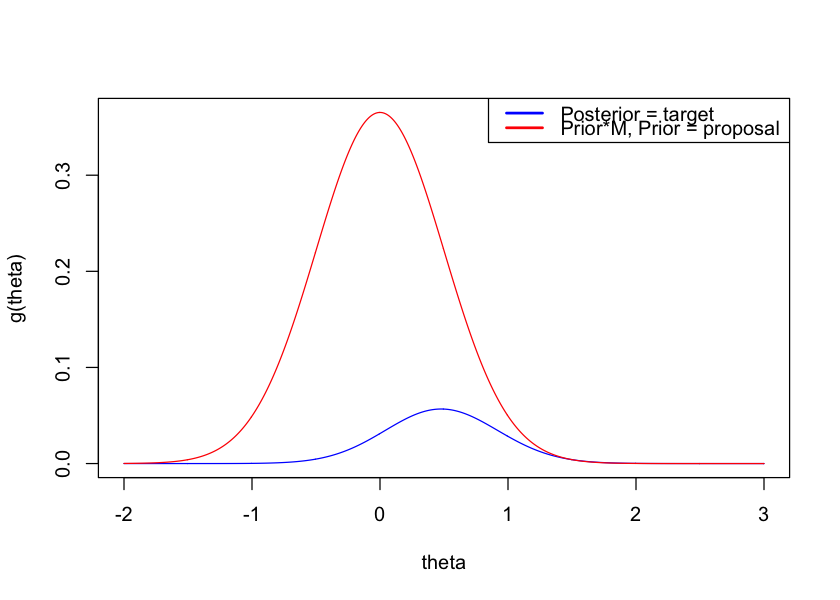

In [88]:
plot(theta, g(theta), type = "l", col = "blue", ylim = c(0,max(M*p(theta))))
lines(theta, M*p(theta), col = "red")
legend("topright",legend=c("Posterior = target","Prior*M, Prior = proposal"),lwd=2.2,col=c("blue","red"))

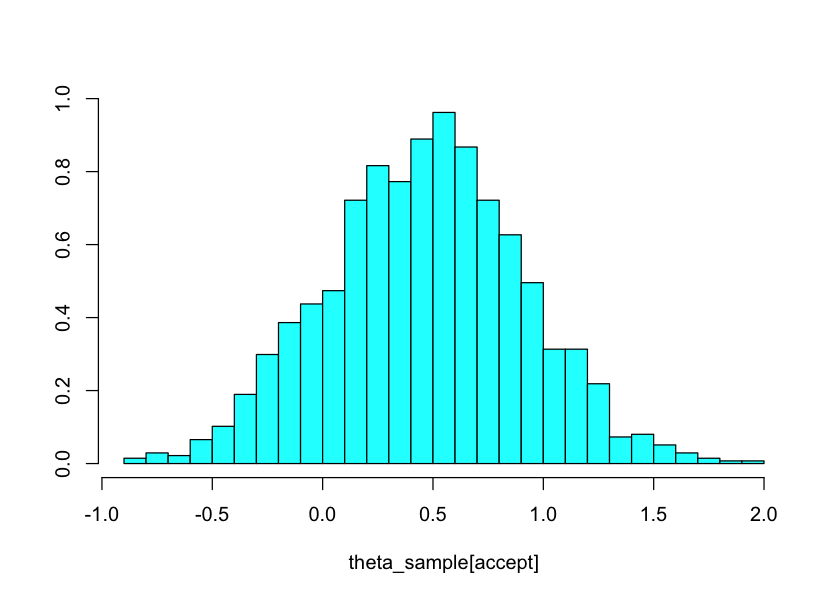

In [91]:
library(MASS)
truehist(theta_sample[accept])

In [92]:
a = sum(theta_sample[accept] >= 0)/length(theta_sample[accept])

Using rejection sampling, the probability for \theta being larger zero is

In [93]:
round(a, 3)

[1] 0.845

### c)

In [94]:
N = 10000
prop_sample <- rnorm(N, mean = mu, sd = sqrt(sigma2))
sum_weights = sum(g(prop_sample)/p(prop_sample))
probs = 1/sum_weights*g(prop_sample)/p(prop_sample)
indices <- sample(1:N, size = N, prob = probs, replace = TRUE)
theta_sir <- prop_sample[indices]

In [95]:
b <- sum(theta_sir >= 0)/length(theta_sir)
b

[1] 0.8675

## Exercise 2

### a)

#### 1. Previous work:

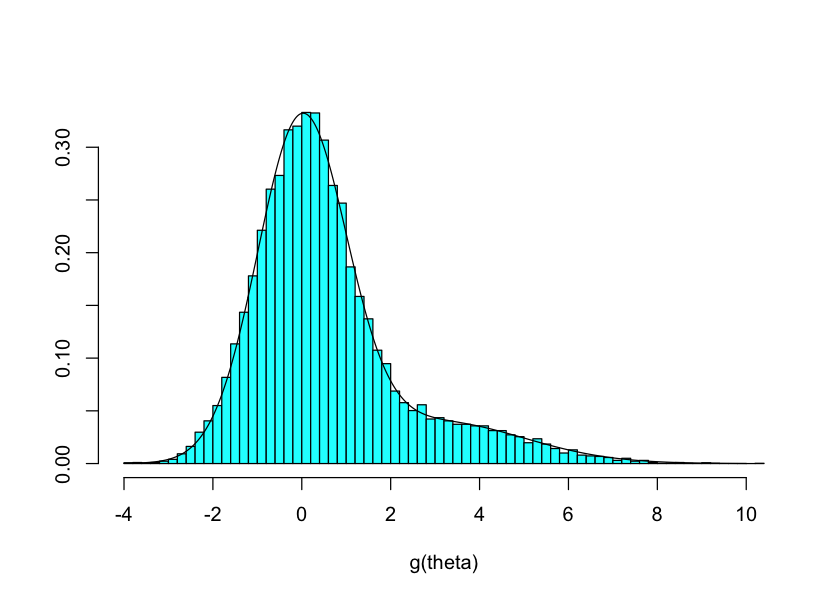

In [96]:
library(MASS)
N <- 20000
gamma <- 0.8
Ind<-rbinom(N,size=1,prob=gamma)
g <- function(theta){Ind*rnorm(N,mean=0,sd=1) + (1-Ind)*rnorm(N,mean=3,sd=2)}
g_pdf <- function(theta){gamma*dnorm(theta,mean=0,sd=1) + (1-gamma)*dnorm(theta,mean=3,sd=2)}
theta <- seq(-4,10,length=1000)
truehist(g(theta))
lines(theta,g_pdf(theta))

#### 2. Metropolis Algorithm with symmetric Gaussian candidate

In [97]:
proposal_sym <- function(theta){rnorm(1, mean = theta, sd = 1)}

run_metropolis <- function(g_pdf, rproposal, startvalue, iterations){
    chain<-array(dim = c(iterations+1,1))
    chain[1] <- startvalue
    
    for(i in 1:iterations){
        theta1 <- rproposal(chain[i])
        accept_prob <- min(1, g_pdf(theta1)/g_pdf(chain[i]))
        
        if(runif(1) <= accept_prob){
            chain[i+1] <- theta1
        } else {
            chain[i+1] <- chain[i]
        }
    }
    
    chain
}
theta0 <- 2
chain_sym <- run_metropolis(g_pdf, proposal_sym, theta0, 2000)

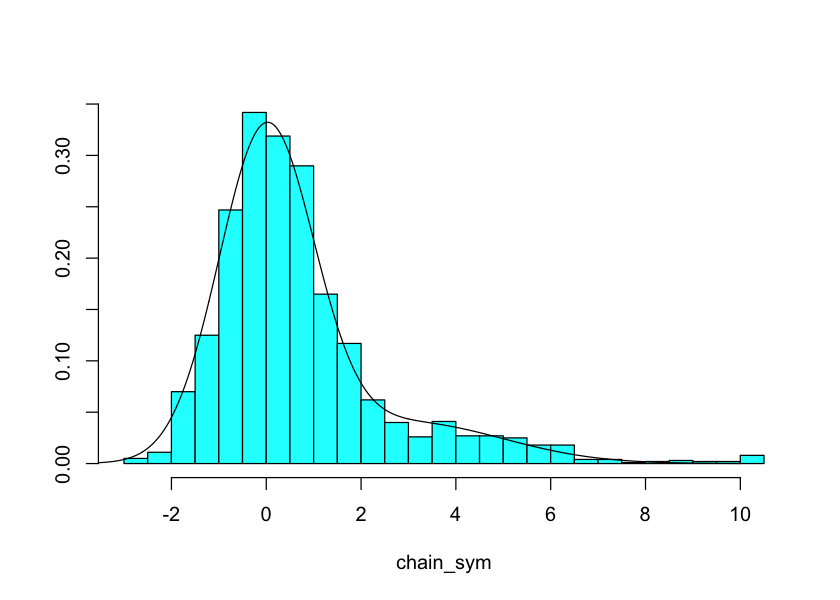

In [98]:
truehist(chain_sym)
lines(theta,g_pdf(theta))

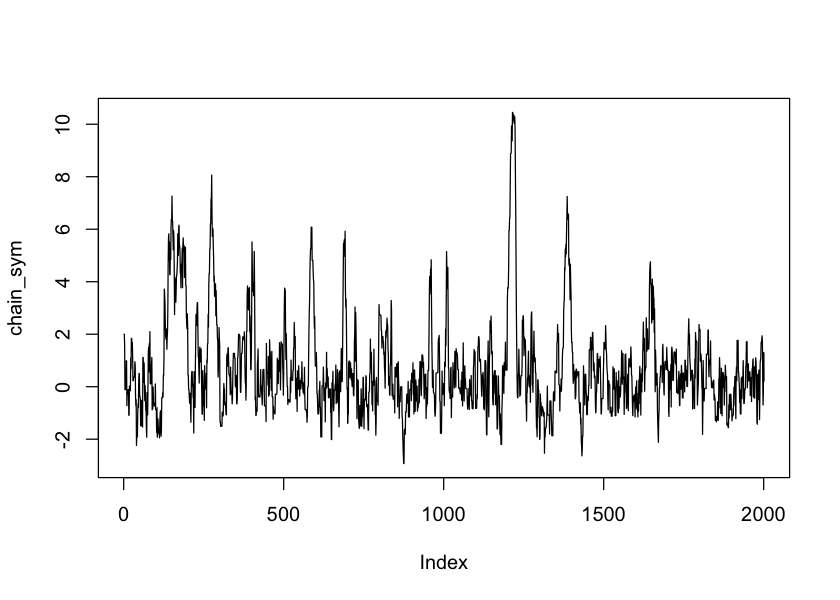

In [99]:
plot(chain_sym, type = "l")

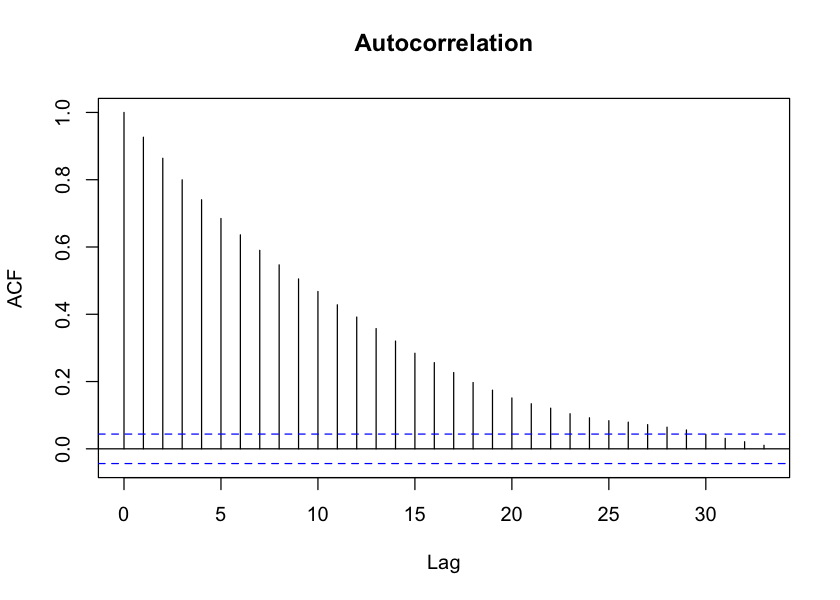

In [100]:
acf(chain_sym, main = "Autocorrelation")

#### 3. Metropolis Hastings algorithm with independent Gaussian candidate

In [101]:
proposal_ind <- function(){rnorm(1, mean = 0, sd = 3)}
proposal_pdf <- function(theta){dnorm(theta, mean = 0, sd = 3)}

run_metropolis_hastings <- function(g_pdf, proposal_pdf, rproposal, startvalue, iterations){
    chain<-array(dim = c(iterations+1,1))
    chain[1] <- startvalue
    
    for(i in 1:iterations){
        theta1 <- rproposal()
        
        accept_prob <- (g_pdf(theta1)*proposal_pdf(chain[i]))/(g_pdf(chain[i])*proposal_pdf(theta1))

        if(runif(1) < accept_prob){
            chain[i+1] <- theta1
        } else {
            chain[i+1] <- chain[i]
        }
    }
    
    chain
}
theta0 <- 0.4448
chain_ind <- run_metropolis_hastings(g_pdf, proposal_pdf, proposal_ind, theta0, 2000)

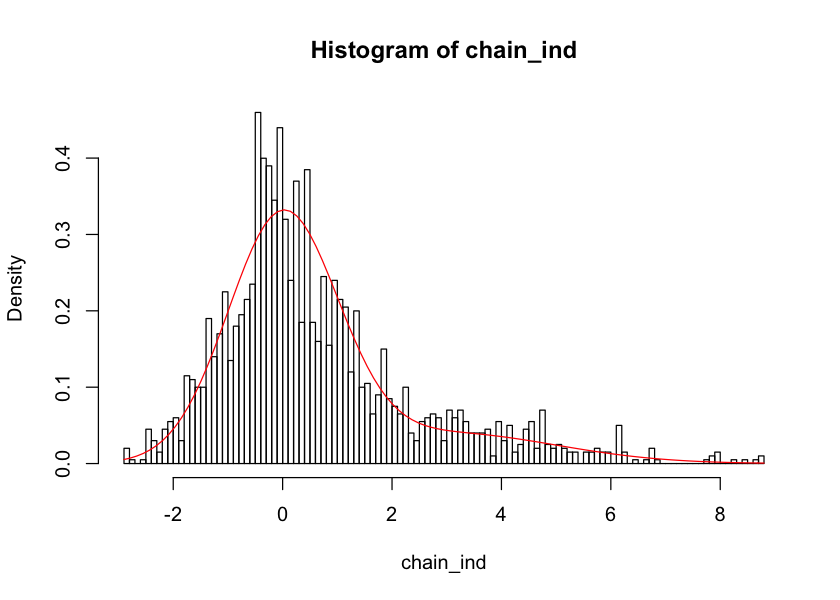

In [102]:
hist(chain_ind, nclass = 100, freq = F)
curve(g_pdf, add = T, col = "red")

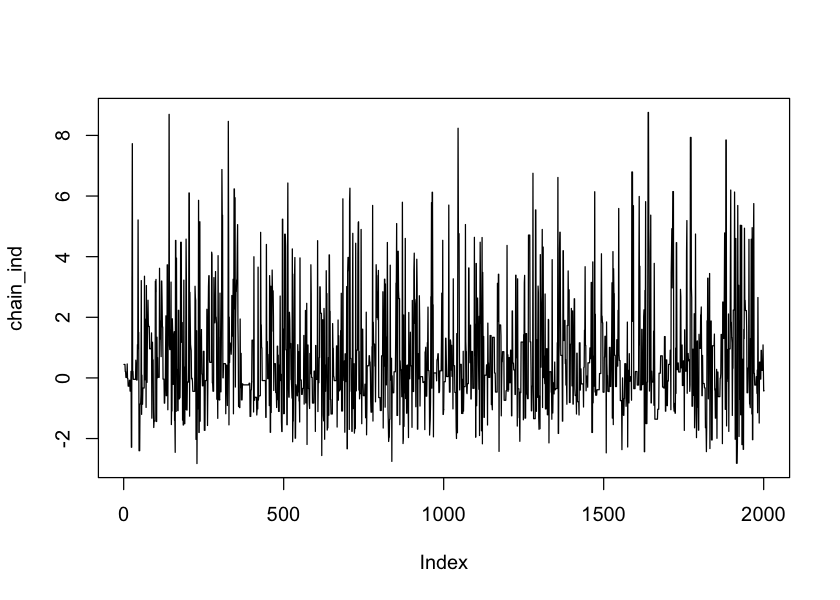

In [103]:
plot(chain_ind, type = "l")

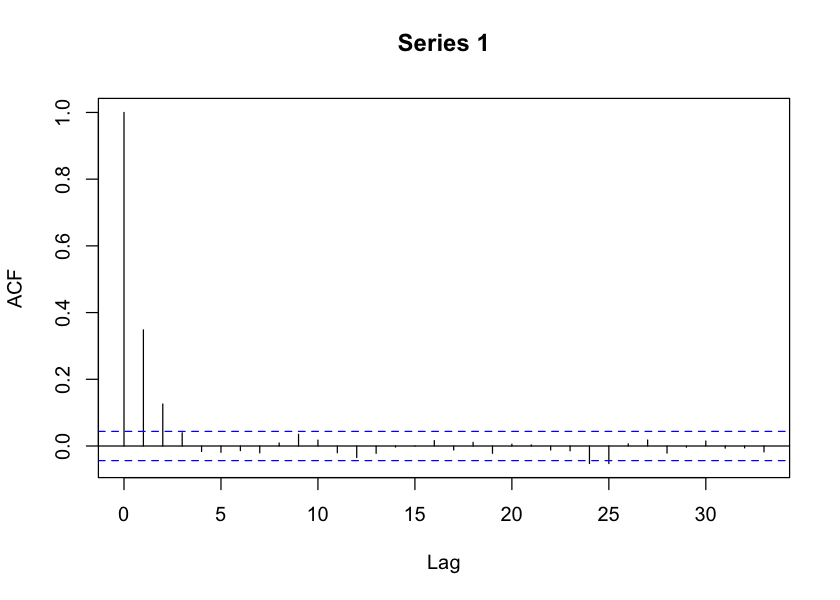

In [104]:
acf(chain_ind)

## Exercise 3

To complete this exercise, we follow the instructions given in exercise 6.4 in the book of Robert and Casella. It states:

Exercise 6.4

Consider the target as the $Gamma(\alpha, \beta)$ distribution and the candidate
as the gamma $G([\alpha], b)$ distribution (where $[\alpha]$ denotes the integer part of $\alpha$).

a. Derive the corresponding Accept/Reject method and show that, when $\beta = 1$,
the optimal choice of $b$ is $b = [\alpha]/\alpha$.

b. Generate 5000 $Gamma(4, 4/4.85)$ random variables to derive a $Gamma(4.85, 1)$ sample
(note that you will get less than 5000 random variables).

c. Use the same sample in the corresponding Metropolis-Hastings algorithm to
generate 5000 $Gamma(4.85, 1)$ random variables.

d. Compare the algorithms using (i) their acceptance rates and (ii) the estimates
of the mean and variance of the $G(4.85, 1)$ along with their errors. (Hint:
Examine the correlation in both samples.)

### Define parameters and functions

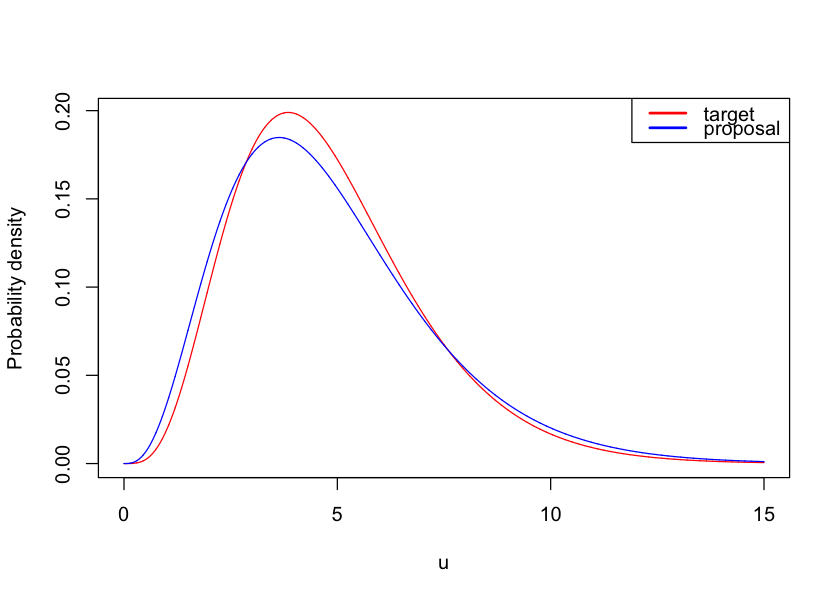

In [316]:
### Target and candidate densities
target_pdf <- function(x){dgamma(x,alpha,beta)}
candidate_pdf <- function(x){dgamma(x,a,b)}

### PARAMS
N = 5000
alpha <- 4.85
beta <- 1
a <- floor(alpha)
b <- a/alpha
u <- seq(0,15,length=10000)

plot(u, target_pdf(u), type = "l", col = "red", ylab = "Probability density")
lines(u, candidate_pdf(u), type = "l", col = "blue")
legend("topright",legend=c("target","proposal"),lwd=2.2,col=c("red","blue"))

#### a. Derive the corresponding Accept/Reject method and show that, when $\beta = 1$, the optimal choice of $b$ is $b = [\alpha]/\alpha = a/\alpha$.

The target density $g(x)$ and the candidate density $h(x)$ are, respectively,

$$
g(x) = G(\alpha, 1) = \frac{1}{\Gamma(\alpha)} x^{\alpha - 1} e^{-x}
$$
and 
$$
h(x) = G(a, b) = \frac{b^a}{\Gamma(a)} x^{a - 1} e^{-bx}
$$
Our goal is to find the smallest $M$ that fulfills
$$
\frac{g(x)}{h(x)} \leq M~\forall~x
$$

to increase the acceptance rate $1/M$ and therefore the efficiency of the algorithm. Let us write the fraction of target over candidate

$$
f(x) = \frac{g(x)}{h(x)} = \frac{\Gamma(a)}{\Gamma(\alpha)b^{a}} x^{\alpha - a} e^{(b-1)x} 
$$

To find the maximum of the function $f(x)$ we compute the derivative with respect to $x$ and set it to zero

$$
\frac{d}{dx} f(x)= \frac{\Gamma(a)}{\Gamma(\alpha)b^{a}} \left((\alpha-a)x^{\alpha-a-1}e^{(b-1)x} + x^{\alpha-a}(b-1)e^{(b-1)x} \right) = 0 \\
\iff (\alpha - a)x^{\alpha-a-1} + x^{\alpha-a}(b-1) = 0 \\
\iff x = \frac{\alpha - a}{1 - b}
$$

We can plug this into $f(x)$ and compute the derivative with respect to b and set it to zero (consider $\alpha \ne a$)

$$
\frac{d}{db} f(b) = const \cdot \left((-a) b^{-a-1} (1 - b)^{a-\alpha} - b^{-a} (a - \alpha) (1 - b)^{a - \alpha - 1} \right) = 0 \\
\iff (-a) b^{-1} = (a - \alpha)(1 - b)^{-1} \\
\iff b = \frac{a}{\alpha},
$$
which is the desired result. 

To derive the entire accept-reject algorithm we also derive a way of sampling from the candidate function with the inverse cdf method, although we could sample from the candidate directly. In particular,
sampling from $Gamma(a,b)$ ($a = floor(\alpha)$, $b = a/\alpha$) is equivalent to sample from the sum of a i.i.d random variables distributed as $Exp(\beta)$ ($\beta = 1$). The inverse cdf of

$$
p(x) = Exp(\beta) = \Bigg\{\begin{aligned} \beta e^{-\beta x},~ x \geq 0 \\ 0,~ otherwise \end{aligned}
$$
is
$$
P^{-1}(y) = - \frac{1}{\beta} log(1-y). 
$$

Let us now implement all this.

In [290]:
require(stats)
inverse_cdf <- function(n){-1/b*log(1-runif(n))}
optim_fct <- function(x){target_pdf(x)/candidate_pdf(x)}
sol <- optimize(optim_fct, interval = c(0,15), maximum = T)
M <- sol$maximum
M

[1] 4.849998

This previous value is the value for M as defined above as the maximum of target over candidate for all x. 

#### b. Generate 5000 $Gamma(4, 4/4.85)$ random variables to derive a $Gamma(4.85, 1)$ sample (note that you will get less than 5000 random variables).

Next, we implement functions to generate the candidate sample and to implement the accept-reject algorithm with the provided parameters (which are defined at the beginning of the exercise).

In [299]:
candidate_generation_inverse_cdf <- function(N = 1){
    candidate_sample <- array(dim=c(N,a))
    for(i in 1:a){
        candidate_sample[,i] <- inverse_cdf(N)
    }

    candidate_sample <- apply(candidate_sample, 1, sum)
}

accept_reject <- function(target_pdf, candidate_pdf, rcandidate, M, N){
    sample <- rcandidate(N)
    accept <- target_pdf(sample)/(M*candidate_pdf(sample))
    u <- runif(N)
    sample[u<accept]
}

Let us run the algorithm and compare the acceptance rate to the theoretical acceptance rate

In [300]:
round(1/M,3)

[1] 0.206

In [301]:
accept <- accept_reject(target_pdf, candidate_pdf, candidate_generation_inverse_cdf, M, N)
accept_rate <- length(accept)/N
accept_rate

[1] 0.2088

These two values are very close, but it varies with every execution. Choosing a larger sample size gives better agreement.

Now we compare the theoretical probability density with the obtained samples from the accept-reject method.

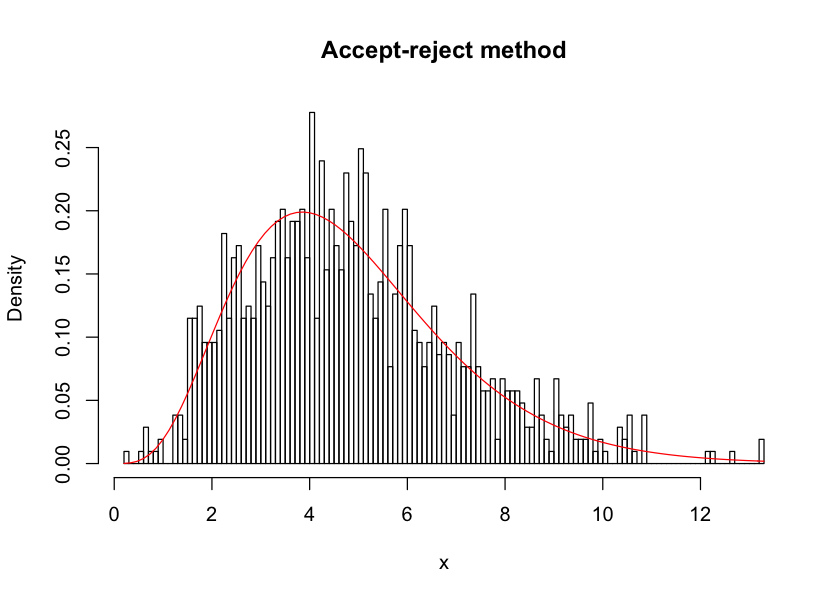

In [304]:
hist(accept, nclass=150, freq = F, main = "Accept-reject method", xlab = "x")
curve(target_pdf,, col = "red", add = T)

#### c. Use the same sample in the corresponding Metropolis-Hastings algorithm to generate 5000 $Gamma(4.85, 1)$ random variables.

In [305]:
run_metropolis_hastings <- function(g_pdf, proposal_pdf, rproposal, startvalue, iterations){
    chain<-array(dim = c(iterations+1,1))
    chain[1] <- startvalue
    
    for(i in 1:iterations){
        theta1 <- rproposal()
        
        accept_prob <- (g_pdf(theta1)*proposal_pdf(chain[i]))/(g_pdf(chain[i])*proposal_pdf(theta1))

        if(runif(1) < accept_prob){
            chain[i+1] <- theta1
        } else {
            chain[i+1] <- chain[i]
        }
    }
    
    chain
}

In [307]:
metr_samples <- run_metropolis_hastings(target_pdf, candidate_pdf, candidate_generation_inverse_cdf, a, N)

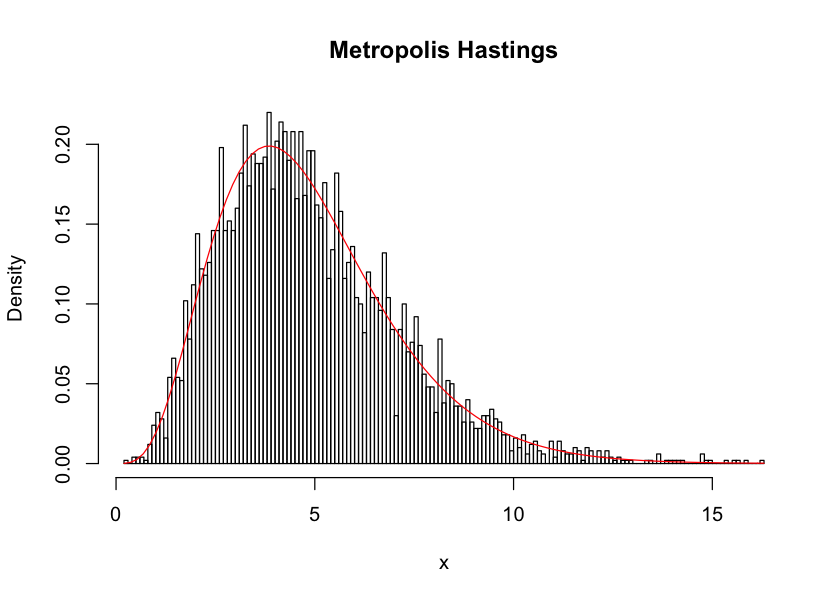

In [308]:
hist(metr_samples, nclass = 150, freq = F, main = "Metropolis Hastings", xlab = "x")
curve(target_pdf, add = T, col = "red")

For some reason the samples of the Metropolis-Hastings follow the theoretical distribution better than the samples of the Accept-Reject method. A comparison of the algorithms can shed light onto this.

#### d. Compare the algorithms using (i) their acceptance rates and (ii) the estimates of the mean and variance of the  G(4.85,1)  along with their errors. (Hint: Examine the correlation in both samples.)

#### (i)

The Metropolis-Hastings acceptance rate is

In [309]:
metr_accept_rate <- length(metr_samples[!duplicated(metr_samples)])/N
metr_accept_rate

[1] 0.939

This acceptance rate is more than 4 times higher than the acceptance rate of the Accept-Reject method, which explains the better agreement to the theoretical curve. Note, that using a burn in interval here is not necessary, as we used an independent candidate generation.

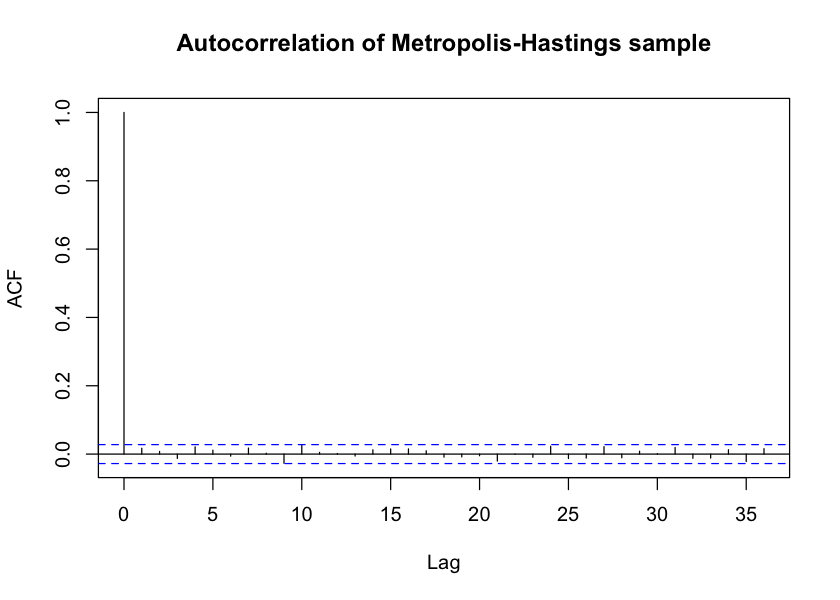

In [310]:
acf(metr_samples, main = "Autocorrelation of Metropolis-Hastings sample")

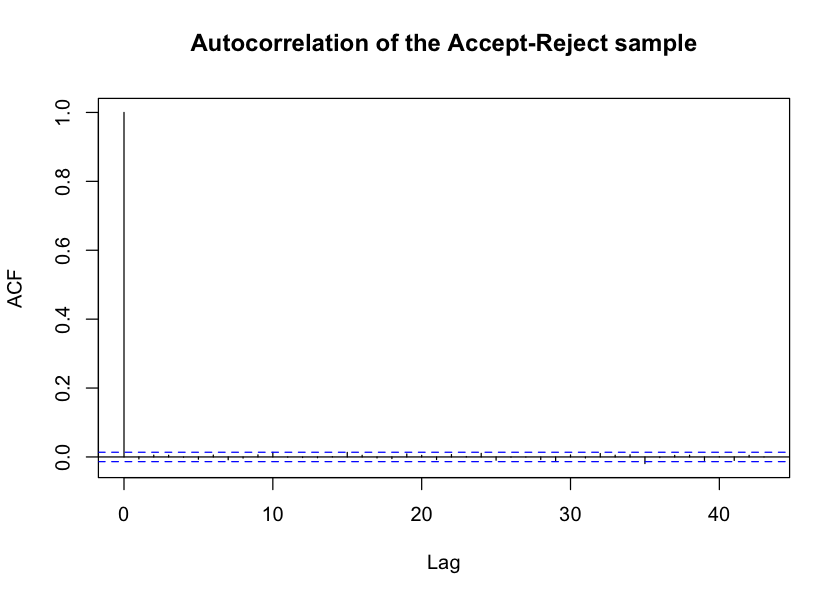

In [311]:
acf(accept_reject_algo$accept, main = "Autocorrelation of the Accept-Reject sample")

As can be seen both samples have negligible autocorrelation, but the accept-reject method has even smaller correlation.

#### (ii)

The theoretical mean and variance of a $Gamma(4.85,1)$ are

$$
E[X] = \frac{\alpha}{\beta} = 4.85 \\
var[X] = \frac{\alpha}{\beta^2} = 4.85
$$

The mean and the variance of the Metropolis-Hastings sample are, respectively

In [314]:
mean(metr_samples)
var(metr_samples)

[1] 4.85083

5.016105


The mean and the variance of the Accept_reject sample are, respectively

In [315]:
mean(accept_reject_algo$accept)
var(accept_reject_algo$accept)

[1] 4.829226

[1] 4.825914